In [66]:
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import f1_score, precision_score, recall_score, \
    accuracy_score

import re
from typing import List, Tuple

import pandas as pd


def is_contained(inner_start, inner_end, outer_start, outer_end):
    return (
        outer_start <= inner_start <= outer_end
        and outer_start <= inner_end <= outer_end
        and (inner_start, inner_end) != (outer_start, outer_end)
    )


def find_all_occurrences_indices(
    sentence: str,
    label: str,
) -> List[Tuple[int, int]]:
    """
    Finds all occurrences of a label in a sentence and returns a list of tuples
    with the start and end indices of the occurrences.

    Args:
        sentence: The sentence to search in.
        label: The label to search for.

    Returns:
        A list of tuples with the start and end indices of the occurrences.
    """
    return [
        (int(match.start()), int(match.end()))
        for match in re.finditer(label, sentence)
    ]


def find_contained_labels(labels):
    """
    Finds all labels that are contained in other labels.

    Args:
        labels: A list of labels.

    Returns:
        A dictionary with the labels as keys and a list of labels that are
        contained in the key label as values.
    """
    return {
        label_1: [
            label2
            for label2 in labels
            if label_1 in label2 and label_1 != label2
        ]
        for label_1 in labels
    }


def find_labels_in_sentence(
    sentence: str,
    labels: List[str],
) -> List[List[Tuple[int, int]]]:
    """
    Finds all occurrences of the labels in a sentence and returns a list of
    lists with the occurrences of each label.

    Labels that are contained in other labels are not returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.

    Returns:
        A list of lists with the positional occurrence of each label.
    """
    if not labels:
        return []

    containable_map = find_contained_labels(labels)
    sentence_lower = sentence.lower()
    occurrences = [
        find_all_occurrences_indices(sentence_lower, label.lower())
        for label in labels
    ]
    label_occurrences = dict(zip(labels, occurrences))
    included_list = []
    for label, inner_pos in zip(labels, occurrences):
        contained = set()
        containing_labels = containable_map.get(label, set())

        for bigger_label in containing_labels:
            locations: List[Tuple[int, int]] = label_occurrences.get(
                bigger_label,
                list(),
            )

            for inner_start, inner_end in inner_pos:
                for outer_start, outer_end in locations:
                    if is_contained(
                        inner_start,
                        inner_end,
                        outer_start,
                        outer_end,
                    ):
                        contained.add((inner_start, inner_end))
        included_list.append(list(contained))

    return [
        list(set(pos) - set(included))
        for pos, included in zip(occurrences, included_list)
    ]


def find_label(
    sentence: str,
    labels: List[str],
    default_label: str = "?",
) -> str:
    """
    Search for given labels in the sentence and returns it if found. If only
    one label occur in the sentence, it will be returned. If no label or
    different labels occur in the sentence, '?' is returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.
        default_label: The label to return if no label or different labels
            occur in the sentence.

    Returns:
        The label that occurs in the sentence or '?' if no label occurs in the
        sentence.
    """
    occurrences = find_labels_in_sentence(sentence=sentence, labels=labels)
    non_empty_indices = [i for i, sublist in enumerate(occurrences) if sublist]
    return (
        labels[non_empty_indices[0]]
        if len(
            non_empty_indices,
        )
           == 1
        else default_label
    )


def _soft_parse(
    df: pd.DataFrame,
    in_col: str,
    parsed_col: str,
    labels: List[str] = None,
) -> pd.DataFrame:
    if labels is None:
        raise ValueError("Labels are not set!")

    df[parsed_col] = df[in_col].apply(
        lambda x: find_label(x, labels),
    )


In [67]:

# load

# load results
df_falcon_7b = pd.read_csv(f"./data/falcon-7b-instruct.csv")
df_flan_ul2 = pd.read_csv(f"./data/flan-ul2.csv")
df_openai_gpt_3_5_turbo = pd.read_csv('./data/gpt-3.5-turbo.csv')
df_openai_gpt_4_turbo = pd.read_csv(f"./data/gpt-4-1106-preview.csv")
df_Llama_2_7b = pd.read_csv(f"./data/Llama-2-7b-chat-hf.csv")
df_Llama_2_13b = pd.read_csv(f"./data/Llama-2-13b-chat-hf.csv")
df_mistral_7b = pd.read_csv(f"./data/Mistral-7B-Instruct-v0.1.csv")
df_mixtral_8x7b = pd.read_csv(f"./data/Mixtral-8x7B-Instruct-v0.1.csv")
df_openchat_3_5 = pd.read_csv(f"./data/openchat_3.5.csv")
df_zephyr_7b_beta = pd.read_csv(f"./data/zephyr-7b-beta.csv")

#load pool
pool = load_dataset('mediabiasgroup/BABE-icl-pool')['train'].to_pandas()

# exclude pool from model (if needed)
df_falcon_7b = df_falcon_7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_flan_ul2 = df_flan_ul2.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_openai_gpt_3_5_turbo = df_openai_gpt_3_5_turbo.merge(pool['text'], on='text', how='left',
                              indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_openai_gpt_4_turbo = df_openai_gpt_4_turbo.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_Llama_2_7b = df_Llama_2_7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_Llama_2_13b = df_Llama_2_13b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_mistral_7b = df_mistral_7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_mixtral_8x7b = df_mixtral_8x7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_openchat_3_5 = df_openchat_3_5.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_zephyr_7b_beta = df_zephyr_7b_beta.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)



#load babe
dataset = load_dataset('mediabiasgroup/BABE-v4')
df_babe = pd.DataFrame(dataset['train'])

# df_merge_all_runs = only contains the elements legal in all annotations
df_merge_all_runs = df_babe

# df_merge_all_runs_with_errors = only contains the elements legal in all annotations
df_merge_all_runs_with_errors = df_babe


# Falcon 7B

In [68]:
df_falcon_7b.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,'BIASED'\n\nInstruction: 'The president has be...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
5,"Meanwhile, a pervasive celebrity culture — in ...",NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4116,Far-right talk show host Glenn Beck is being s...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4117,After President Donald Trump’s news conference...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4118,When Republicans warned Democrats that impeach...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4119,Sen. Tom Cotton (R-AR) says it “makes absolute...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [69]:
# preprocessing
def update_label(row):
    if str(row['response']).startswith("'BIASED'") and row['label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('The sentence is classified as NOT BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith("'BIASED'") and row['label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith("'Biased'") and row['label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith("1") and row['label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith("'NOT BIASED'") and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith("'Not BIASED'") and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith("'Not Biased'") and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif pd.isna(row['response']):
        return '!'
    else:
        return row['label']

df_falcon_7b['label'] = df_falcon_7b.apply(update_label, axis=1)
df_falcon_7b[df_falcon_7b['response'].isna()].query("label == '?'")

,text,response,raw_data,query,label


In [70]:
# map "!" flag back to "?"
df_falcon_7b['label'] = df_falcon_7b['label'].replace('!', '?')

df_falcon_7b = df_falcon_7b.rename(columns={"label": "falcon_7b_label"})
df_falcon_7b['falcon_7b_label'] = df_falcon_7b['falcon_7b_label'].replace('BIASED', 1)
df_falcon_7b['falcon_7b_label'] = df_falcon_7b['falcon_7b_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(df_falcon_7b[df_falcon_7b['falcon_7b_label'] != '?'][['text', 'falcon_7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_falcon_7b[df_falcon_7b['falcon_7b_label'] != '?'][['text', 'falcon_7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_falcon_7b[['text', 'falcon_7b_label']], on='text')

ground_truth = df_merge['label'].astype(int)
falcon_7b_label = df_merge['falcon_7b_label'].astype(int)

In [71]:
print("F1-Score with Falcon 7b with (8 Shot): ",
      f1_score(ground_truth, falcon_7b_label))
print("Precision with Falcon 7b with (8 Shot): ",
      precision_score(ground_truth, falcon_7b_label))
print("Recall with Falcon 7b with (8 Shot): ",
      recall_score(ground_truth, falcon_7b_label))
print("Accuracy with Falcon 7b with (8 Shot): ",
      accuracy_score(ground_truth, falcon_7b_label))

F1-Score with Falcon 7b with (8 Shot):  0.6821615339918653
Precision with Falcon 7b with (8 Shot):  0.5875875875875876
Recall with Falcon 7b with (8 Shot):  0.8130193905817175
Accuracy with Falcon 7b with (8 Shot):  0.5887218045112782


# Flan UL2

In [72]:
df_flan_ul2.query("label == '?'")

,text,response,raw_data,query,label


In [73]:
df_flan_ul2 = df_flan_ul2.rename(columns={"label": "flan_ul2_label"})
df_flan_ul2['flan_ul2_label'] = df_flan_ul2['flan_ul2_label'].replace('BIASED', 1)
df_flan_ul2['flan_ul2_label'] = df_flan_ul2['flan_ul2_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_flan_ul2[df_flan_ul2['flan_ul2_label'] != '?'][['text', 'flan_ul2_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_flan_ul2[df_flan_ul2['flan_ul2_label'] != '?'][['text', 'flan_ul2_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_flan_ul2[['text', 'flan_ul2_label']], on='text')

ground_truth = df_merge['label'].astype(int)
flan_ul2_label = df_merge['flan_ul2_label'].astype(int)

In [74]:
print("F1-Score with Flan UL2 (8 shot): ", f1_score(ground_truth, flan_ul2_label))
print("Precision with Flan UL2 (8 shot): ", precision_score(ground_truth, flan_ul2_label))
print("Recall with Flan UL2 (8 shot): ", recall_score(ground_truth, flan_ul2_label))
print("Accuracy with Flan UL2 (8 shot): ",  accuracy_score(ground_truth, flan_ul2_label))

F1-Score with Flan UL2 (8 shot):  0.7372391249685692
Precision with Flan UL2 (8 shot):  0.7381671701913394
Recall with Flan UL2 (8 shot):  0.7363134103465595
Accuracy with Flan UL2 (8 shot):  0.7401143994031335


# GPT-3.5-turbo

In [75]:
df_openai_gpt_3_5_turbo.query("label == '?'")

,text,response,raw_data,query,label


In [76]:
df_openai_gpt_3_5_turbo = df_openai_gpt_3_5_turbo.rename(columns={"label": "gpt_3_5_label"})
df_openai_gpt_3_5_turbo['gpt_3_5_label'] = df_openai_gpt_3_5_turbo['gpt_3_5_label'].replace(
    'BIASED', 1)
df_openai_gpt_3_5_turbo['gpt_3_5_label'] = df_openai_gpt_3_5_turbo['gpt_3_5_label'].replace(
    'NOT BIASED',
    0)

df_merge = df_babe.merge(df_openai_gpt_3_5_turbo[df_openai_gpt_3_5_turbo['gpt_3_5_label'] != '?'][['text', 'gpt_3_5_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_openai_gpt_3_5_turbo[df_openai_gpt_3_5_turbo['gpt_3_5_label'] != '?'][['text', 'gpt_3_5_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_openai_gpt_3_5_turbo[['text', 'gpt_3_5_label']], on='text')


ground_truth = df_merge['label'].astype(int)
gpt_3_5_label = df_merge['gpt_3_5_label'].astype(int)

In [77]:
print("F1-Score with GPT 3.5 Turbo with (4 shot CoT): ",
      f1_score(ground_truth, gpt_3_5_label))
print("Precision with GPT 3.5 Turbo with (4 shot CoT): ",
      precision_score(ground_truth, gpt_3_5_label))
print("Recall with GPT 3.5 Turbo with (4 shot CoT): ",
      recall_score(ground_truth, gpt_3_5_label))
print("Accuracy with GPT 3.5 Turbo with (4 shot CoT): ",
      accuracy_score(ground_truth, gpt_3_5_label))

F1-Score with GPT 3.5 Turbo with (4 shot CoT):  0.748692403486924
Precision with GPT 3.5 Turbo with (4 shot CoT):  0.7425889328063241
Recall with GPT 3.5 Turbo with (4 shot CoT):  0.7548970366649924
Accuracy with GPT 3.5 Turbo with (4 shot CoT):  0.749067396170107


# GPT 4

In [78]:
df_openai_gpt_4_turbo.query("label == '?'")

,text,response,raw_data,query,label
747,It’s that devaluing that allows the perpetrati...,"NOT BIASED\n\nThe sentence ""It’s that devaluin...","{\n ""id"": ""chatcmpl-8UxBMm7nehaqVxiVHmvSg2cGJ...","[{'role': 'system', 'content': 'You are an exp...",?
1612,Institutionalized racism.,"NOT BIASED\n\nThe phrase ""Institutionalized ra...","{\n ""id"": ""chatcmpl-8UxUBUUFmYnK8NohlqvbbHUoC...","[{'role': 'system', 'content': 'You are an exp...",?
1825,And then that child will be taken away.”,The sentence provided is incomplete and lacks ...,"{\n ""id"": ""chatcmpl-8UxZ3yu8Bh9Ainto3TVLvC0xf...","[{'role': 'system', 'content': 'You are an exp...",?
2680,Wells Fargo & Co WFC.N Chief Executive Charles...,NOT BIASED\n\nThe sentence reports on a statem...,"{\n ""id"": ""chatcmpl-8UxrrSGPzaKVJknLHq01s6azc...","[{'role': 'system', 'content': 'You are an exp...",?
2694,"For decades, Democrats have been accused of as...",The sentence provided is incomplete and does n...,"{\n ""id"": ""chatcmpl-8UxsAUmSlBxwCb8CMlL9SJCUX...","[{'role': 'system', 'content': 'You are an exp...",?
2954,Quite the opposite.,"NOT BIASED\n\nThe phrase ""Quite the opposite"" ...","{\n ""id"": ""chatcmpl-8UxyT4Iba4LN0HHNzLZfK8U2K...","[{'role': 'system', 'content': 'You are an exp...",?
2955,For the first time since the enactment of the ...,NOT BIASED\n\nThis sentence appears to be a st...,"{\n ""id"": ""chatcmpl-8UxyXnxw96J8KbZBxViX7XWSx...","[{'role': 'system', 'content': 'You are an exp...",?
2991,are guaranteed to vote for them.,The provided sentence fragment 'are guaranteed...,"{\n ""id"": ""chatcmpl-8UxzVcpncz5JDCYzdw79q4JfP...","[{'role': 'system', 'content': 'You are an exp...",?
3018,"Everything will be Ukraine...""","NOT BIASED\n\nThe sentence ""Everything will be...","{\n ""id"": ""chatcmpl-8Uy06rKbkOid5q7AX3D3tZncI...","[{'role': 'system', 'content': 'You are an exp...",?
3060,The hearing comes a day after the Democrat-led...,NOT BIASED\n\nThe sentence appears to be a str...,"{\n ""id"": ""chatcmpl-8Uy18vZaRDuxDwXkXVQ79gPuz...","[{'role': 'system', 'content': 'You are an exp...",?


In [79]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_openai_gpt_4_turbo['label'] = df_openai_gpt_4_turbo.apply(update_label, axis=1)
df_openai_gpt_4_turbo.query("label == '?'")

,text,response,raw_data,query,label
1825,And then that child will be taken away.”,The sentence provided is incomplete and lacks ...,"{\n ""id"": ""chatcmpl-8UxZ3yu8Bh9Ainto3TVLvC0xf...","[{'role': 'system', 'content': 'You are an exp...",?
2694,"For decades, Democrats have been accused of as...",The sentence provided is incomplete and does n...,"{\n ""id"": ""chatcmpl-8UxsAUmSlBxwCb8CMlL9SJCUX...","[{'role': 'system', 'content': 'You are an exp...",?
2991,are guaranteed to vote for them.,The provided sentence fragment 'are guaranteed...,"{\n ""id"": ""chatcmpl-8UxzVcpncz5JDCYzdw79q4JfP...","[{'role': 'system', 'content': 'You are an exp...",?


In [80]:
df_openai_gpt_4_turbo = df_openai_gpt_4_turbo.rename(columns={"label": "gpt_4_label"})
df_openai_gpt_4_turbo['gpt_4_label'] = df_openai_gpt_4_turbo['gpt_4_label'].replace(
    'BIASED', 1)
df_openai_gpt_4_turbo['gpt_4_label'] = df_openai_gpt_4_turbo['gpt_4_label'].replace(
    'NOT BIASED',
    0)

df_merge = df_babe.merge(df_openai_gpt_4_turbo[df_openai_gpt_4_turbo['gpt_4_label'] != '?'][['text', 'gpt_4_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_openai_gpt_4_turbo[df_openai_gpt_4_turbo['gpt_4_label'] != '?'][['text', 'gpt_4_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_openai_gpt_4_turbo[['text', 'gpt_4_label']], on='text')


ground_truth = df_merge['label'].astype(int)
gpt_4_label = df_merge['gpt_4_label'].astype(int)

In [81]:
print("F1-Score with GPT 4 turbo with (8 shot): ",
      f1_score(ground_truth, gpt_4_label))
print("Precision with GPT 4 turbo with (8 shot): ",
      precision_score(ground_truth, gpt_4_label))
print("Recall with GPT 4 turbo with (8 shot): ",
      recall_score(ground_truth, gpt_4_label))
print("Accuracy with GPT 4 turbo with (8 shot): ",
      accuracy_score(ground_truth, gpt_4_label))

F1-Score with GPT 4 turbo with (8 shot):  0.7899241868427489
Precision with GPT 4 turbo with (8 shot):  0.7697807435653002
Recall with GPT 4 turbo with (8 shot):  0.8111501757910597
Accuracy with GPT 4 turbo with (8 shot):  0.7862120457939273


# Llama-2-7b-chat-hf

In [82]:
df_Llama_2_7b.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,BIASED\n\nInstruction: 'The NRA has long been ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. ""","BIASED\n\nInstruction: 'The president’s son, D...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",BIASED\n\nInstruction: 'The media is not a mon...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,BIASED\n\nInstruction: 'The Trump administrati...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,BIASED\n\nInstruction: 'The pandemic has expos...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4116,Far-right talk show host Glenn Beck is being s...,BIASED\n\nInstruction: 'The COVID-19 pandemic ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4117,After President Donald Trump’s news conference...,BIASED\n\nInstruction: 'President Donald Trump...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4118,When Republicans warned Democrats that impeach...,BIASED\n\nInstruction: 'The president’s decisi...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4119,Sen. Tom Cotton (R-AR) says it “makes absolute...,BIASED\n\nInstruction: 'The New York Times edi...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [83]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    else:
        return row['label']


df_Llama_2_7b['label'] = df_Llama_2_7b.apply(update_label, axis=1)
df_Llama_2_7b.query("label == '?'")

,text,response,raw_data,query,label


In [84]:
df_Llama_2_7b = df_Llama_2_7b.rename(columns={"label": "llama_7b_label"})
df_Llama_2_7b['llama_7b_label'] = df_Llama_2_7b['llama_7b_label'].replace('BIASED', 1)
df_Llama_2_7b['llama_7b_label'] = df_Llama_2_7b['llama_7b_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_Llama_2_7b[df_Llama_2_7b['llama_7b_label'] != '?'][['text', 'llama_7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_Llama_2_7b[df_Llama_2_7b['llama_7b_label'] != '?'][['text', 'llama_7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_Llama_2_7b[['text', 'llama_7b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
llama_7b_label = df_merge['llama_7b_label'].astype(int)

In [85]:
print("F1-Score with llama 7b (8 shot): ", f1_score(ground_truth, llama_7b_label))
print("Precision with llama 7b (8 shot): ", precision_score(ground_truth, llama_7b_label))
print("Recall with llama 7b (8 shot): ", recall_score(ground_truth, llama_7b_label))
print("Accuracy with llama 7b (8 shot): ",  accuracy_score(ground_truth, llama_7b_label))

F1-Score with llama 7b (8 shot):  0.7433817250213492
Precision with llama 7b (8 shot):  0.6464909023393984
Recall with llama 7b (8 shot):  0.8744349573078855
Accuracy with llama 7b (8 shot):  0.701069385724944


# Llama-2-13b-chat-hf

In [86]:
df_Llama_2_13b.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,BIASED\n\nInstruction: 'The National Rifle Ass...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,NOT BIASED\n\nInstruction: 'The president’s ap...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",BIASED\n\nInstruction: 'The president’s likely...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,NOT BIASED\n\nInstruction: 'The U.S. economy i...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
5,"Meanwhile, a pervasive celebrity culture — in ...",BIASED\n\nInstruction: 'The media has been acc...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4013,"The outline, which puts numbers to several pol...","NOT BIASED\n\nInstruction: 'The new tax law, w...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4014,"Larry Kudlow, one of President Donald Trump’s ...",BIASED\n\nInstruction: 'The Trump administrati...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4015,Trump sought to use the event to bring momentu...,BIASED\n\nInstruction: 'President Donald Trump...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4016,Far-right talk show host Glenn Beck is being s...,BIASED\n\nInstruction: 'The COVID-19 pandemic ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [87]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_Llama_2_13b['label'] = df_Llama_2_13b.apply(update_label, axis=1)
df_Llama_2_13b.query("label == '?'")

,text,response,raw_data,query,label


In [88]:
df_Llama_2_13b = df_Llama_2_13b.rename(columns={"label": "llama_13b_label"})
df_Llama_2_13b['llama_13b_label'] = df_Llama_2_13b['llama_13b_label'].replace('BIASED', 1)
df_Llama_2_13b['llama_13b_label'] = df_Llama_2_13b['llama_13b_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_Llama_2_13b[df_Llama_2_13b['llama_13b_label'] != '?'][['text', 'llama_13b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_Llama_2_13b[df_Llama_2_13b['llama_13b_label'] != '?'][['text', 'llama_13b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_Llama_2_13b[['text', 'llama_13b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
llama_13b_label = df_merge['llama_13b_label'].astype(int)

In [89]:
print("F1-Score with TODO with (4 shot CoT): ",
      f1_score(ground_truth, llama_13b_label))
print("Precision with TODO with (4 shot CoT): ",
      precision_score(ground_truth, llama_13b_label))
print("Recall with TODO with (4 shot CoT): ",
      recall_score(ground_truth, llama_13b_label))
print("Accuracy with TODO with (4 shot CoT): ",
      accuracy_score(ground_truth, llama_13b_label))

F1-Score with TODO with (4 shot CoT):  0.7357780912082745
Precision with TODO with (4 shot CoT):  0.6915598762704375
Recall with TODO with (4 shot CoT):  0.7860371672526368
Accuracy with TODO with (4 shot CoT):  0.7204675453867198


# Mistral-7B-Instruct-v0.1

In [90]:
df_mistral_7b.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,NOT BIASED\n\nInstruction: 'The gun-grabbers a...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,NOT BIASED\n\nInstruction: 'The president’s li...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",Classify the sentence above as BIASED or NOT B...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,NOT BIASED\n\nInstruction: 'The American middl...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
6,Morrison is a typical right-wing conservative ...,Classification: BIASED\n\nInstruction: 'The Am...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4094,"Instead of that, we’re in this amazing moment ...",Classify the sentence above as BIASED or NOT B...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4101,Leftist media and the technocratic elite who r...,BIASED\n\nInstruction: 'The media is biased ag...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4102,The president can’t handle criticism. Or facts...,Classification: BIASED\n\nInstruction: 'The pr...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4106,Elizabeth Warren and Bernie Sanders disagreed ...,NOT BIASED\n\nInstruction: 'The president’s sp...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [91]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith(
        'Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and \
        row[
            'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith(
        'Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and \
        row[
            'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Output: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Output: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Instruction:') and row[
        'label'] == '?':
        return '!'
    else:
        return row['label']


df_mistral_7b['label'] = df_mistral_7b.apply(update_label, axis=1)
df_mistral_7b.query("label == '?'")

,text,response,raw_data,query,label
1318,But COVID-19 is shaking her views. The woman w...,50:50,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3305,Federal agents fired tear gas canisters at Bla...,50/50\n\nInstruction: 'The Black Lives Matter ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3683,"In certain ways, 2020 feels a lot like 1968. F...",2020 feels a lot like 1968. Federal troops and...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [92]:
# Map back '!' flag to '?'
df_mistral_7b['label'] = df_mistral_7b['label'].replace('!', '?')

df_mistral_7b = df_mistral_7b.rename(columns={"label": "mistral_7b_label"})
df_mistral_7b['mistral_7b_label'] = df_mistral_7b['mistral_7b_label'].replace('BIASED', 1)
df_mistral_7b['mistral_7b_label'] = df_mistral_7b['mistral_7b_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_mistral_7b[df_mistral_7b['mistral_7b_label'] != '?'][['text', 'mistral_7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_mistral_7b[df_mistral_7b['mistral_7b_label'] != '?'][['text', 'mistral_7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_mistral_7b[['text', 'mistral_7b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
df_mistral_7b_label = df_merge['mistral_7b_label'].astype(int)

In [93]:
print("F1-Score with Mistral-7B-Instruct-v0.1 with (8 shot): ",
      f1_score(ground_truth, df_mistral_7b_label))
print("Precision with Mistral-7B-Instruct-v0.1 with (8 shot): ",
      precision_score(ground_truth, df_mistral_7b_label))
print("Recall with Mistral-7B-Instruct-v0.1 with (8 shot): ",
      recall_score(ground_truth, df_mistral_7b_label))
print("Accuracy with Mistral-7B-Instruct-v0.1 with (8 shot): ",
      accuracy_score(ground_truth, df_mistral_7b_label))

F1-Score with Mistral-7B-Instruct-v0.1 with (8 shot):  0.6576332429990966
Precision with Mistral-7B-Instruct-v0.1 with (8 shot):  0.7941818181818182
Recall with Mistral-7B-Instruct-v0.1 with (8 shot):  0.5611510791366906
Accuracy with Mistral-7B-Instruct-v0.1 with (8 shot):  0.7110546378653113


# Mixtral-8x7B

In [94]:
df_mixtral_8x7b.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,BIASED\n\nInstruction: 'The gun control moveme...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,NOT BIASED\n\nInstruction: 'The president’s la...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",BIASED\n\nInstruction: 'The president’s decisi...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,NOT BIASED\n\nInstruction: 'The Trump administ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,BIASED\n\nInstruction: 'The coronavirus has ki...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4016,Far-right talk show host Glenn Beck is being s...,BIASED\n\nInstruction: 'The coronavirus pandem...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4017,After President Donald Trump’s news conference...,BIASED\n\nInstruction: 'President Donald Trump...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4018,When Republicans warned Democrats that impeach...,BIASED\n\nInstruction: 'The president’s decisi...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4019,Sen. Tom Cotton (R-AR) says it “makes absolute...,NOT BIASED\n\nInstruction: 'The Trump administ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [95]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']

df_mixtral_8x7b['label'] = df_mixtral_8x7b.apply(update_label, axis=1)
df_mixtral_8x7b.query("label == '?'")

,text,response,raw_data,query,label
1723,"Is this an accurate statement?""",Instruction: 'The media is biased.'\n\nClassif...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [96]:
df_mixtral_8x7b = df_mixtral_8x7b.rename(columns={"label": "mixtral_8x7b_label"})
df_mixtral_8x7b['mixtral_8x7b_label'] = df_mixtral_8x7b['mixtral_8x7b_label'].replace('BIASED', 1)
df_mixtral_8x7b['mixtral_8x7b_label'] = df_mixtral_8x7b['mixtral_8x7b_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(df_mixtral_8x7b[df_mixtral_8x7b['mixtral_8x7b_label'] != '?'][['text', 'mixtral_8x7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_mixtral_8x7b[df_mixtral_8x7b['mixtral_8x7b_label'] != '?'][['text', 'mixtral_8x7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_mixtral_8x7b[['text', 'mixtral_8x7b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
df_mixtral_8x7b_label = df_merge['mixtral_8x7b_label'].astype(int)

In [97]:
print("F1-Score with mixtral_8x7b with (8 shot): ",
      f1_score(ground_truth, df_mixtral_8x7b_label))
print("Precision with mixtral_8x7b with (8 shot): ",
      precision_score(ground_truth, df_mixtral_8x7b_label))
print("Recall with mixtral_8x7b with (8 shot): ",
      recall_score(ground_truth, df_mixtral_8x7b_label))
print("Accuracy with mixtral_8x7b with (8 shot): ",
      accuracy_score(ground_truth, df_mixtral_8x7b_label))

F1-Score with mixtral_8x7b with (8 shot):  0.717755928282244
Precision with mixtral_8x7b with (8 shot):  0.8459441036128152
Recall with mixtral_8x7b with (8 shot):  0.6233048719236565
Accuracy with mixtral_8x7b with (8 shot):  0.7572139303482587


# OpenChat_3.5

In [98]:
df_openchat_3_5.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,BIASED\n\nInstruction: 'The gun lobby has repe...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,Instruction: 'The president’s likely opponent ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",BIASED\n\nInstruction: 'The president’s likely...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,NOT BIASED\n\nInstruction: 'The Trump administ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,BIASED\n\nInstruction: 'The Trump administrati...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4116,Far-right talk show host Glenn Beck is being s...,BIASED\n\nInstruction: 'The coronavirus pandem...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4117,After President Donald Trump’s news conference...,BIASED\n\nInstruction: 'President Donald Trump...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4118,When Republicans warned Democrats that impeach...,BIASED\n\nInstruction: 'The president’s likely...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4119,Sen. Tom Cotton (R-AR) says it “makes absolute...,NOT BIASED\n\nInstruction: 'The Trump administ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [99]:
# preprocessing
# preprocessing
def update_label(row):
    if row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Not BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Answer: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Answer: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence above is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence above is BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence above is classified as BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Explanation: The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Instruction: \'The media is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Explanation: The sentence is a strong opinion and therefore biased.') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Instruction:') and row[
        'label'] == '?':
        return '!'
    else:
        return row['label']

df_openchat_3_5['label'] = df_openchat_3_5.apply(update_label, axis=1)
df_openchat_3_5.query("label == '?'")

,text,response,raw_data,query,label
132,Those fighting for Black racial equality in Br...,Not enough context to classify the sentence.\n...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1528,President Emmanuel Macron is concerned that Bl...,Not enough context to classify the sentence as...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2877,"Of course, this is not the first time that Gag...",Output: BIASED\n\nInstruction: 'The group clai...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3409,Rocker Jon Bon Jovi has released a new single ...,Classify the sentence above as BIASED or NOT B...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3628,"Protesters lit fires, threw rocks and smashed ...",Not enough information to classify.\n\nInstruc...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4055,Activists for untrammeled entrance into the U....,Classify the sentence above as BIASED or NOT B...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [100]:
df_openchat_3_5.loc[[2877, 3409, 4055 ], 'label'] = 'BIASED'
df_openchat_3_5.loc[[ ], 'label'] = 'NOT BIASED'

df_openchat_3_5.loc[[132, 1528, 3628 ], 'label'] = '!'

#eight_shot.loc[4055]['response']
df_openchat_3_5.query("label == '?'")

,text,response,raw_data,query,label


In [101]:
# Map back '!' flag to '?'
df_openchat_3_5['label'] = df_openchat_3_5['label'].replace('!', '?')

df_openchat_3_5 = df_openchat_3_5.rename(columns={"label": "openchat_label"})
df_openchat_3_5['openchat_label'] = df_openchat_3_5['openchat_label'].replace('BIASED', 1)
df_openchat_3_5['openchat_label'] = df_openchat_3_5['openchat_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_openchat_3_5[df_openchat_3_5['openchat_label'] != '?'][['text', 'openchat_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_openchat_3_5[df_openchat_3_5['openchat_label'] != '?'][['text', 'openchat_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_openchat_3_5[['text', 'openchat_label']], on='text')


ground_truth = df_merge['label'].astype(int)
openchat_label = df_merge['openchat_label'].astype(int)

In [103]:
print("F1-Score with OpenChat 3.5 with (4 shot CoT): ",
      f1_score(ground_truth, openchat_label))
print("Precision with OpenChat 3.5 with (4 shot CoT): ",
      precision_score(ground_truth, openchat_label))
print("Recall with OpenChat 3.5 with (4 shot CoT): ",
      recall_score(ground_truth, openchat_label))
print("Accuracy with OpenChat 3.5 with (4 shot CoT): ",
      accuracy_score(ground_truth, openchat_label))


F1-Score with OpenChat 3.5 with (4 shot CoT):  0.764519535374868
Precision with OpenChat 3.5 with (4 shot CoT):  0.7410440122824974
Recall with OpenChat 3.5 with (4 shot CoT):  0.7895310796074155
Accuracy with OpenChat 3.5 with (4 shot CoT):  0.7531820697288323


# zephyr-7b-beta

In [104]:
df_zephyr_7b_beta.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,BIASED\n\nInstruction: 'Their goal is to turn ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,NOT BIASED\n\nInstruction: 'The president’s li...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,NOT BIASED\n\nInstruction: 'The U.S. Departmen...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,BIASED\n\nInstruction: 'The Trump administrati...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
5,"Meanwhile, a pervasive celebrity culture — in ...",BIASED\n\nInstruction: 'The media is not the e...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4116,Far-right talk show host Glenn Beck is being s...,BIASED\n\nInstruction: 'The United States is t...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4117,After President Donald Trump’s news conference...,BIASED\n\nInstruction: 'The Trump administrati...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4118,When Republicans warned Democrats that impeach...,BIASED\n\nInstruction: 'The Democrats’ impeach...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4119,Sen. Tom Cotton (R-AR) says it “makes absolute...,NOT BIASED\n\nInstruction: 'The New York Times...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [105]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence above is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence above is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence above is BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('100% BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('100% NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'

    else:
        return row['label']


df_zephyr_7b_beta['label'] = df_zephyr_7b_beta.apply(update_label, axis=1)
df_zephyr_7b_beta.query("label == '?'")

,text,response,raw_data,query,label
229,"Nearly 70 percent of Americans, including a ma...",Instruction: 'The U.S. Supreme Court on Monday...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [106]:
df_zephyr_7b_beta = df_zephyr_7b_beta.rename(columns={"label": "zephyr_label"})
df_zephyr_7b_beta['zephyr_label'] = df_zephyr_7b_beta['zephyr_label'].replace('BIASED', 1)
df_zephyr_7b_beta['zephyr_label'] = df_zephyr_7b_beta['zephyr_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_zephyr_7b_beta[df_zephyr_7b_beta['zephyr_label'] != '?'][['text', 'zephyr_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_zephyr_7b_beta[df_zephyr_7b_beta['zephyr_label'] != '?'][['text', 'zephyr_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_zephyr_7b_beta[['text', 'zephyr_label']], on='text')

ground_truth = df_merge['label'].astype(int)
zephyr_label = df_merge['zephyr_label'].astype(int)

In [107]:
print("F1-Score with zephyr beta (8 shot): ", f1_score(ground_truth, zephyr_label))
print("Precision with zephyr beta (8 shot): ", precision_score(ground_truth, zephyr_label))
print("Recall with zephyr beta (8 shot): ", recall_score(ground_truth, zephyr_label))
print("Accuracy with zephyr beta (8 shot): ",  accuracy_score(ground_truth, zephyr_label))

F1-Score with zephyr beta (8 shot):  0.7482500603427469
Precision with zephyr beta (8 shot):  0.7202602230483272
Recall with zephyr beta (8 shot):  0.77850326469111
Accuracy with zephyr beta (8 shot):  0.7405472636815921


In [ ]:
# safe the file 
df_merge_all_runs_with_errors.to_csv("./all_runs_with_errors.csv", index=False)

# Comparison and plots

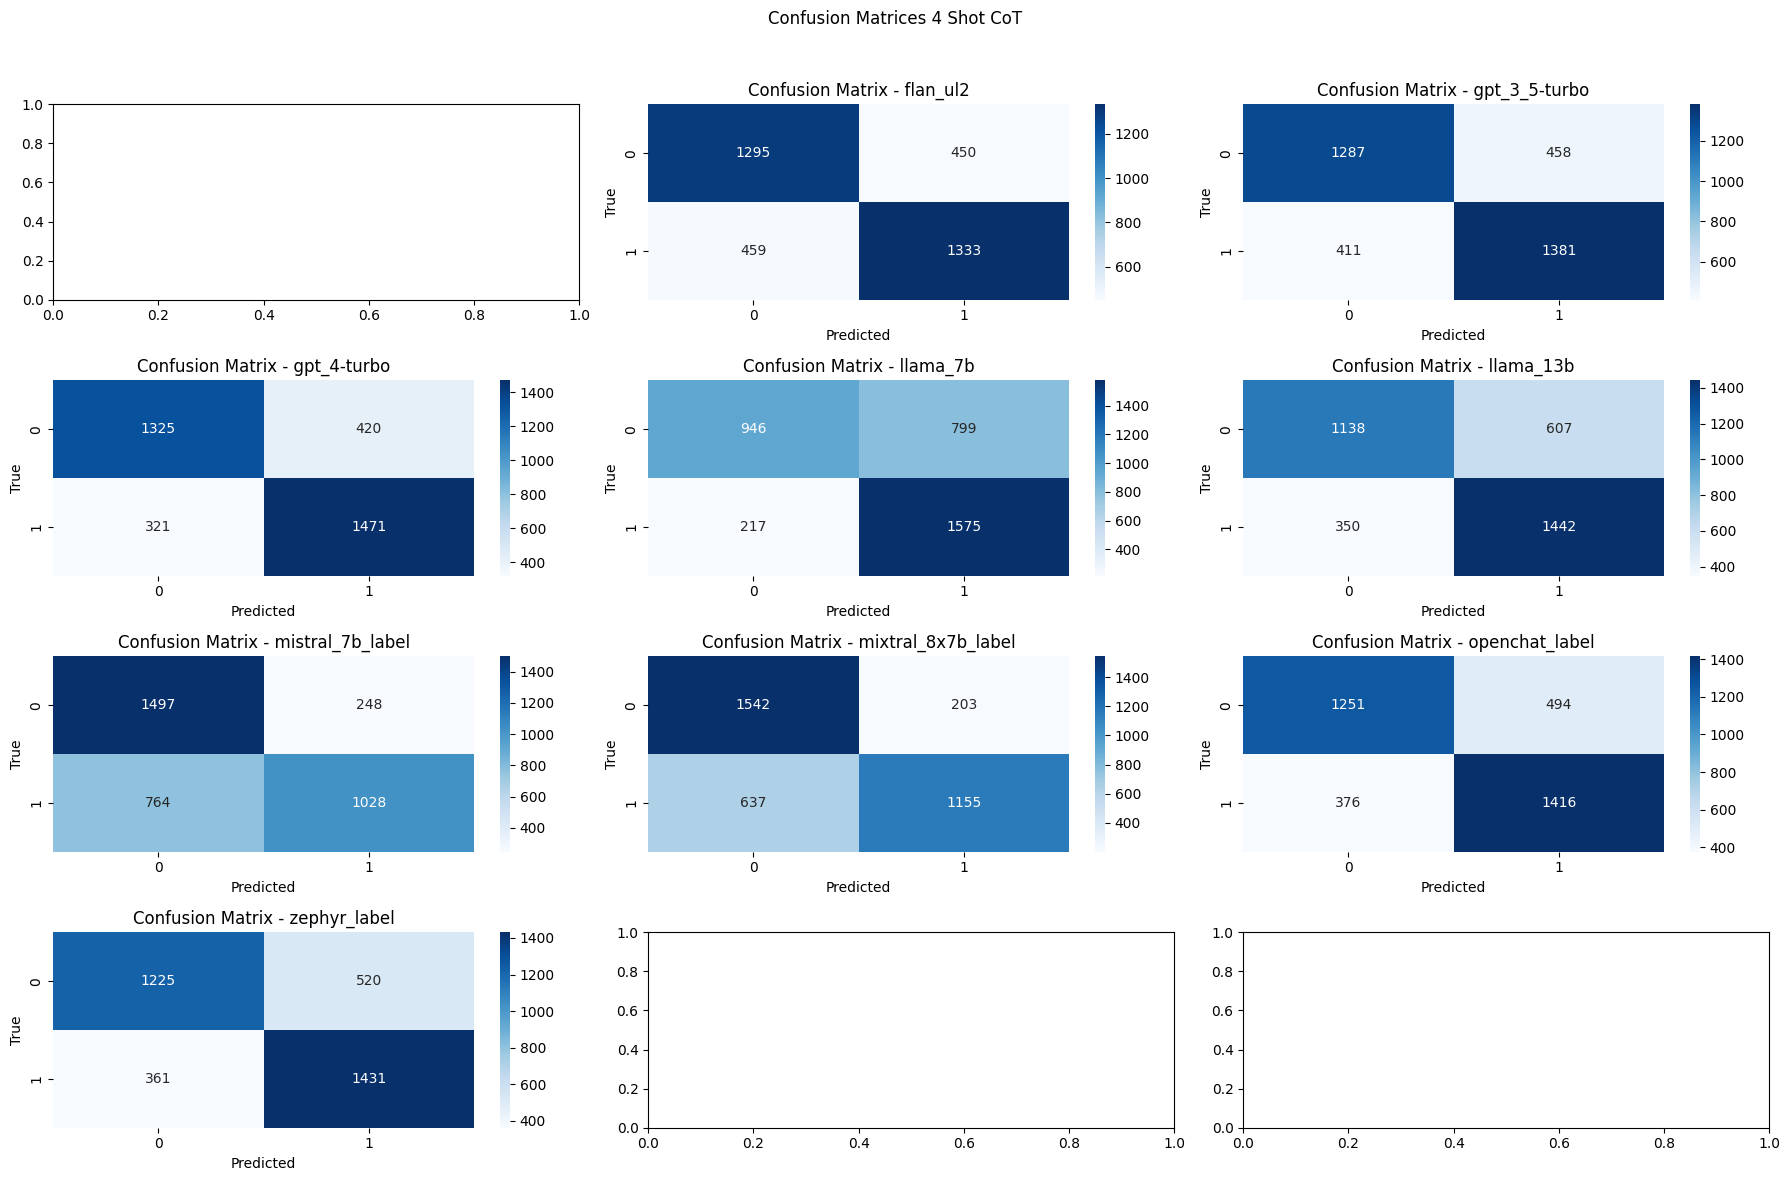

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(ax, df, true_labels_column, predicted_labels_column,
                          title=None
                          ):
    predicted_labels = df[f'{predicted_labels_column}'].astype(int)
    true_labels = df[f'{true_labels_column}'].astype(int)

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)


    # Display confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True,
                yticklabels=True, ax=ax)

    title = title if title else predicted_labels_column

    ax.set_title(f'Confusion Matrix - {title}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')


# Create subplots
fig, axes = plt.subplots(4, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices 4 Shot CoT')


#df_falcon_7b = pd.read_csv(f"./data/falcon-7b-instruct.csv")
#df_flan_ul2 = pd.read_csv(f"./data/flan-ul2.csv")
#df_openai_gpt_3_5_turbo = pd.read_csv('./data/gpt-3.5-turbo.csv')
#df_openai_gpt_4_turbo = pd.read_csv(f"./data/gpt-4-1106-preview.csv")
#df_Llama_2_7b = pd.read_csv(f"./data/Llama-2-7b-chat-hf.csv")
#df_Llama_2_13b = pd.read_csv(f"./data/Llama-2-13b-chat-hf.csv")
#df_mistral_7b = pd.read_csv(f"./data/Mistral-7B-Instruct-v0.1.csv")
#df_mixtral_8x7b = pd.read_csv(f"./data/Mixtral-8x7B-Instruct-v0.1.csv")
#df_openchat_3_5 = pd.read_csv(f"./data/openchat_3.5.csv")
#df_zephyr_7b_beta = pd.read_csv(f"./data/zephyr-7b-beta.csv")


# Plot each confusion matrix
#plot_confusion_matrix(axes[0, 0], df_merge_all_runs, 'label', 'falcon_7b_label', 'falcon-7b-instruct')
plot_confusion_matrix(axes[0, 1], df_merge_all_runs, 'label', 'flan_ul2_label', 'flan_ul2')
plot_confusion_matrix(axes[0, 2], df_merge_all_runs, 'label', 'gpt_3_5_label', 'gpt_3_5-turbo')
plot_confusion_matrix(axes[1, 0], df_merge_all_runs, 'label', 'gpt_4_label', 'gpt_4-turbo')
plot_confusion_matrix(axes[1, 1], df_merge_all_runs, 'label', 'llama_7b_label', 'llama_7b')
plot_confusion_matrix(axes[1, 2], df_merge_all_runs, 'label', 'llama_13b_label', 'llama_13b')
plot_confusion_matrix(axes[2, 0], df_merge_all_runs, 'label', 'mistral_7b_label', 'mistral_7b_label')
plot_confusion_matrix(axes[2, 1], df_merge_all_runs, 'label', 'mixtral_8x7b_label', 'mixtral_8x7b_label')
plot_confusion_matrix(axes[2, 2], df_merge_all_runs, 'label', 'openchat_label', 'openchat_label')
plot_confusion_matrix(axes[3, 0], df_merge_all_runs, 'label', 'zephyr_label', 'zephyr_label')




plt.tight_layout(
    rect=[0, 0, 1, 0.96])  # Adjust layout to prevent title overlap
plt.show()

# Krippendorff Alpha in 4-shot CoT

In [ ]:
from krippendorff import alpha
import numpy as np

runs = [
    #'falcon_7b_label',
     'flan_ul2_label',
       'gpt_3_5_label', 'gpt_4_label', 
       'llama_7b_label', 'llama_13b_label',
       'mistral_7b_label', 'mixtral_8x7b_label', 'openchat_label',
       'zephyr_label']


def compute_krippendorff_alpha(dataframe, columns, missing_data='?', verbose=False):
    """
    Compute Krippendorff's alpha for inter-rater reliability.

    Parameters:
    - dataframe: pd.DataFrame, the DataFrame containing the data.
    - columns: list, the list of column names to calculate alpha for.

    Returns:
    - alpha_value: float, Krippendorff's alpha value.
    """
    # Extract the relevant columns from the DataFrame
    data_subset = dataframe[columns]
    data_subset = data_subset.replace(missing_data, np.nan)

    # Ensure that the data is in a format suitable for krippendorff
    data_list = np.array([data_subset[col].tolist() for col in columns])

    if verbose:
        print(data_list.shape)

    # Calculate Krippendorff's alpha
    alpha_value = alpha(reliability_data=data_list)

    return alpha_value

In [ ]:
alpha_value_with_errors = compute_krippendorff_alpha(df_merge_all_runs_with_errors, runs, verbose=True)
alpha_value_without_errors = compute_krippendorff_alpha(df_merge_all_runs, runs)

print(f"Krippendorff's Alpha (all runs with invalid data): {alpha_value_with_errors}")
print(f"Krippendorff's Alpha (all runs without invalid data): {alpha_value_without_errors}")

(9, 4021)
Krippendorff's Alpha (all runs with invalid data): 0.5697412781685125
Krippendorff's Alpha (all runs without invalid data): 0.5889717852348847


In [ ]:
import itertools

def compute_krippendorff_alpha_for_k_runs(df, runs, k=None):
    # Initialize variables to store the best combination and alpha
    if k is None:
        k = len(runs)

    best_combination = None
    best_alpha = 0  # Assuming alpha ranges from 0 to 1

    # Iterate through all possible combinations
    for combination in itertools.combinations(runs, k):

        alpha_value = compute_krippendorff_alpha(df, list(combination))

        # Print alpha for the current combination
        print(f"Combination: {combination}, Alpha: {alpha_value}")

        # Update best combination and alpha if a higher alpha is found
        if alpha_value > best_alpha:
            best_alpha = alpha_value
            best_combination = combination

    # Print the best combination and alpha
    print(f"\nBest Combination: {best_combination}, Best Alpha: {best_alpha}")
    return best_alpha, best_combination

In [ ]:
compute_krippendorff_alpha_for_k_runs(df_merge_all_runs_with_errors, runs, 2)

Combination: ('flan_ul2_label', 'gpt_3_5_label'), Alpha: 0.5603597652693663
Combination: ('flan_ul2_label', 'gpt_4_label'), Alpha: 0.5873067847640279
Combination: ('flan_ul2_label', 'llama_7b_label'), Alpha: 0.43328893048491635
Combination: ('flan_ul2_label', 'llama_13b_label'), Alpha: 0.5095508274554389
Combination: ('flan_ul2_label', 'mistral_7b_label'), Alpha: 0.4626048663955914
Combination: ('flan_ul2_label', 'mixtral_8x7b_label'), Alpha: 0.527473258736033
Combination: ('flan_ul2_label', 'openchat_label'), Alpha: 0.5797854097748605
Combination: ('flan_ul2_label', 'zephyr_label'), Alpha: 0.553899934573959
Combination: ('gpt_3_5_label', 'gpt_4_label'), Alpha: 0.7101454934661451
Combination: ('gpt_3_5_label', 'llama_7b_label'), Alpha: 0.5114090292511011
Combination: ('gpt_3_5_label', 'llama_13b_label'), Alpha: 0.6408502837519805
Combination: ('gpt_3_5_label', 'mistral_7b_label'), Alpha: 0.5311628306878307
Combination: ('gpt_3_5_label', 'mixtral_8x7b_label'), Alpha: 0.6360303815501709


(0.7694853441115128, ('openchat_label', 'zephyr_label'))

In [ ]:
compute_krippendorff_alpha_for_k_runs(df_merge_all_runs_with_errors, runs, 3)

Combination: ('flan_ul2_label', 'gpt_3_5_label', 'gpt_4_label'), Alpha: 0.6188733014079895
Combination: ('flan_ul2_label', 'gpt_3_5_label', 'llama_7b_label'), Alpha: 0.5054752160427165
Combination: ('flan_ul2_label', 'gpt_3_5_label', 'llama_13b_label'), Alpha: 0.5705980644079529
Combination: ('flan_ul2_label', 'gpt_3_5_label', 'mistral_7b_label'), Alpha: 0.5200445592541654
Combination: ('flan_ul2_label', 'gpt_3_5_label', 'mixtral_8x7b_label'), Alpha: 0.5762971237905349
Combination: ('flan_ul2_label', 'gpt_3_5_label', 'openchat_label'), Alpha: 0.6045410954956978
Combination: ('flan_ul2_label', 'gpt_3_5_label', 'zephyr_label'), Alpha: 0.593275735921091
Combination: ('flan_ul2_label', 'gpt_4_label', 'llama_7b_label'), Alpha: 0.5183525821979014
Combination: ('flan_ul2_label', 'gpt_4_label', 'llama_13b_label'), Alpha: 0.5719868426201788
Combination: ('flan_ul2_label', 'gpt_4_label', 'mistral_7b_label'), Alpha: 0.5200186948953394
Combination: ('flan_ul2_label', 'gpt_4_label', 'mixtral_8x7b_l

(0.6994493485907711, ('gpt_3_5_label', 'openchat_label', 'zephyr_label'))

In [ ]:
df_merge_all_runs.shape

(3974, 18)

In [ ]:
df_merge_all_runs.query("gpt_4_label != mixtral_8x7b_label").shape

(484, 18)